In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  

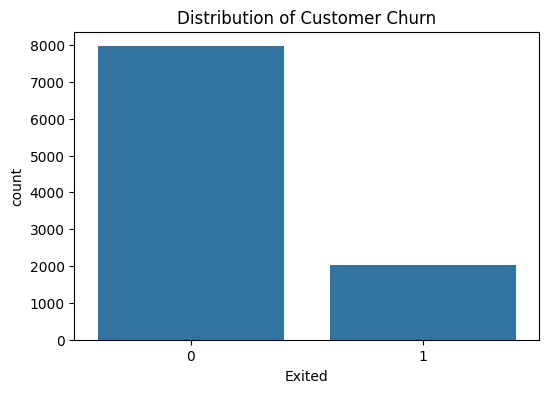


Geography counts:
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender counts:
Gender
Male      5457
Female    4543
Name: count, dtype: int64


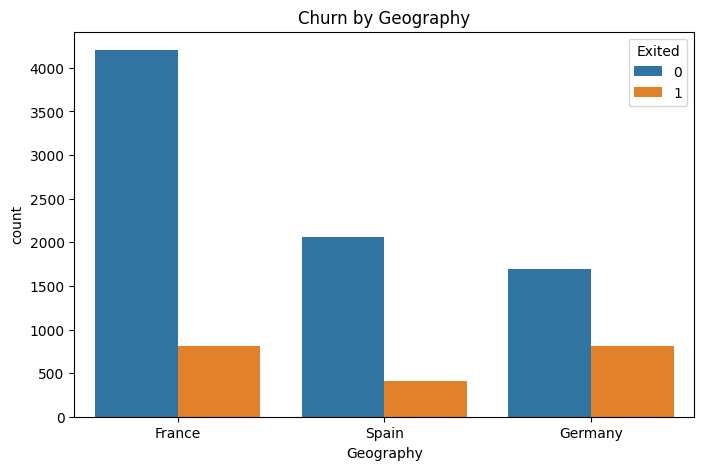

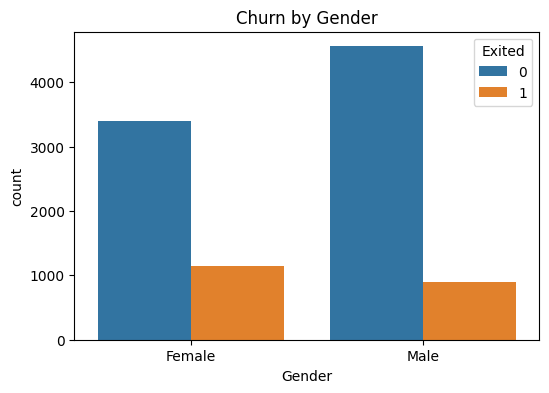

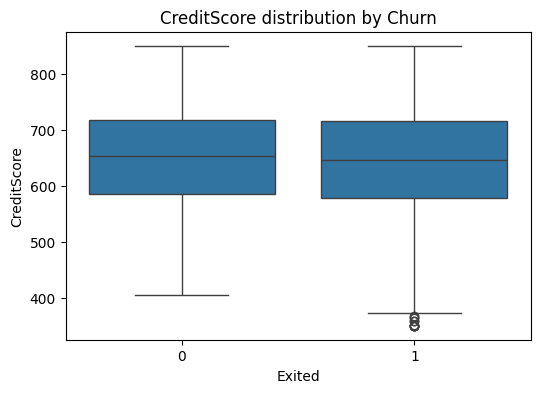

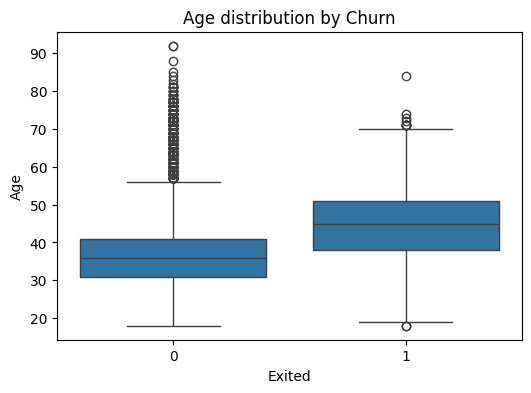

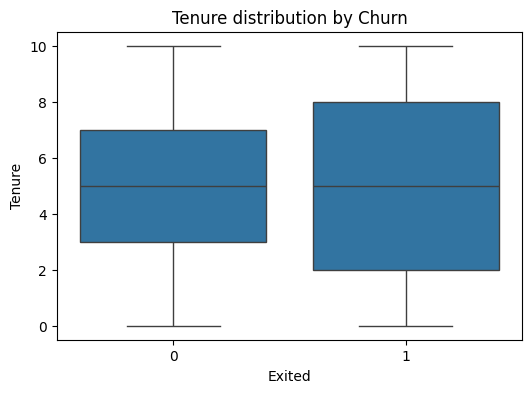

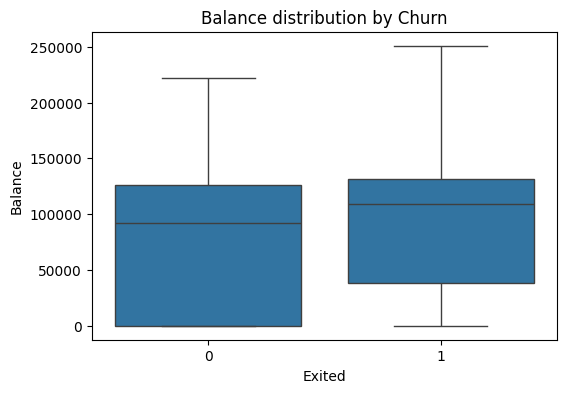

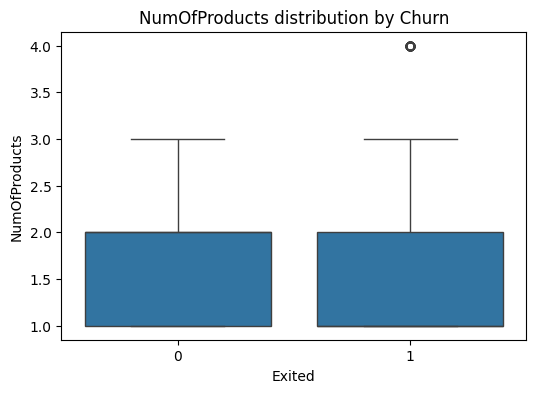

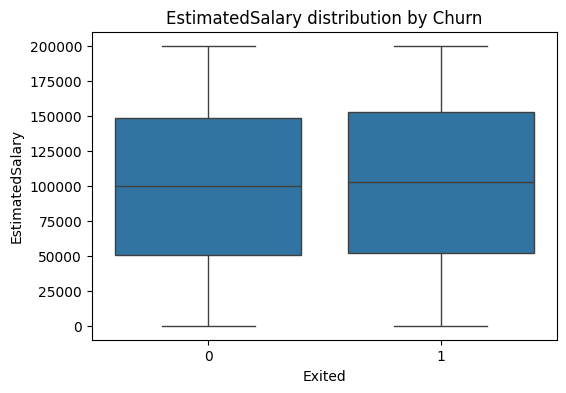

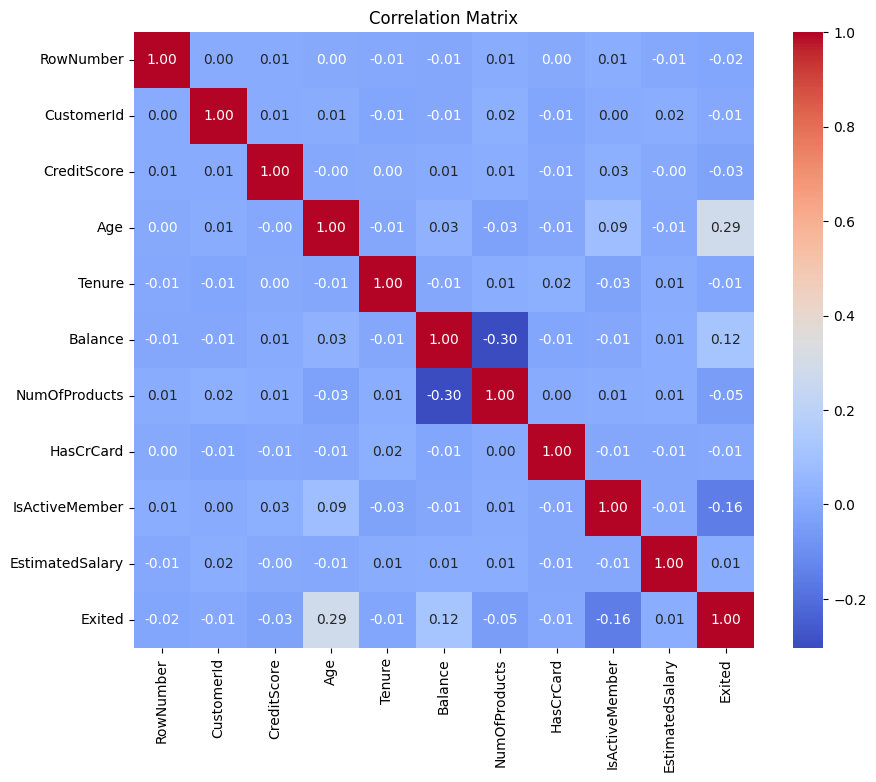

In [11]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Hp\Downloads\ANN Home Assignment\ANN Home Assignment\Churn_Modelling.csv")

# 1. Basic info and summary stats
print("First 5 rows:")
print(data.head())

print("\nData info:")
print(data.info())

print("\nSummary statistics:")
print(data.describe())

# 2. Check missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# 3. Target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=data)
plt.title('Distribution of Customer Churn')
plt.show()

# 4. Categorical variables exploration
print("\nGeography counts:")
print(data['Geography'].value_counts())

print("\nGender counts:")
print(data['Gender'].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x='Geography', hue='Exited', data=data)
plt.title('Churn by Geography')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Exited', data=data)
plt.title('Churn by Gender')
plt.show()

# 5. Numerical variables distributions by churn status
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exited', y=feature, data=data)
    plt.title(f'{feature} distribution by Churn')
    plt.show()

# 6. Correlation matrix
# Drop non-numeric columns for correlation
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Now compute correlation
plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [12]:
# IQR-based capping for chosen columns
for col in ['Age', 'CreditScore']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    print(f"Capping '{col}': lower={lower:.2f}, upper={upper:.2f}")
    data[col] = data[col].clip(lower=lower, upper=upper)


Capping 'Age': lower=14.00, upper=62.00
Capping 'CreditScore': lower=383.00, upper=919.00


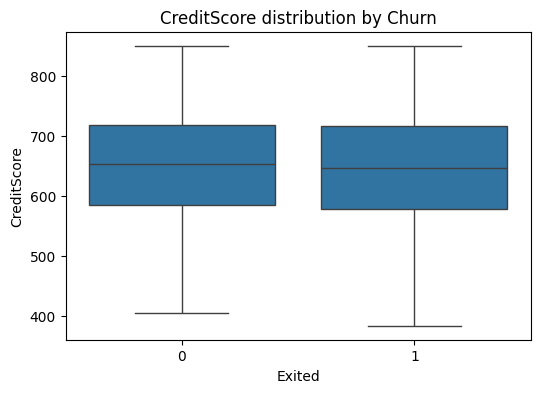

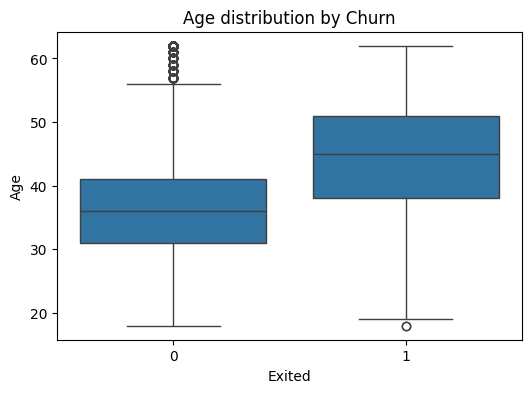

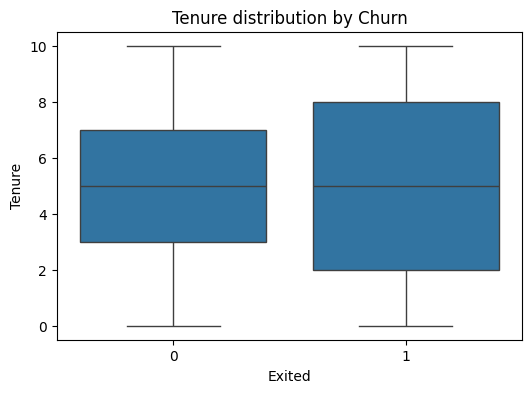

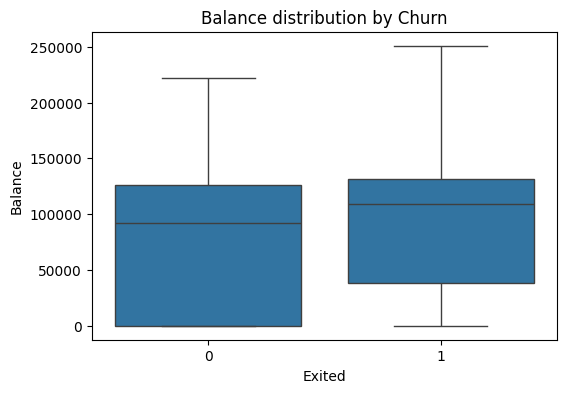

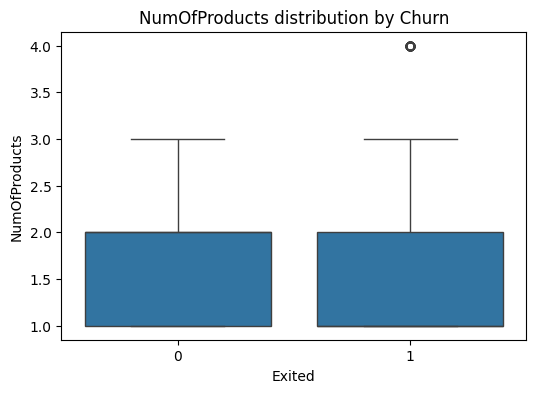

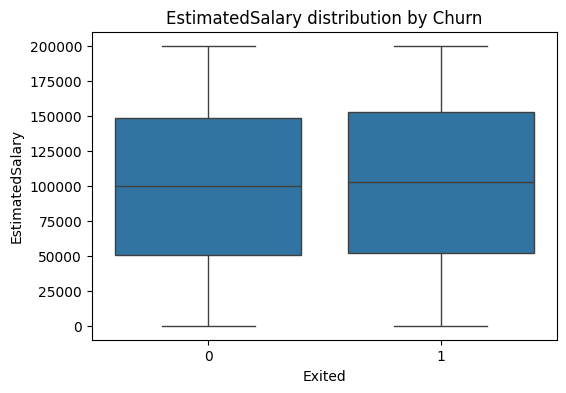

In [13]:
for feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exited', y=feature, data=data)
    plt.title(f'{feature} distribution by Churn')
    plt.show()


In [17]:
# 1. Drop irrelevant columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# 2. Encode categorical variables
# Gender: Male/Female → 0/1
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})

# Geography: One-hot encoding (drop_first=True avoids dummy variable trap)
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

# 3. Split features and target
X = data.drop('Exited', axis=1)
y = data['Exited']

# 4. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 6. Feature scaling (standardization) after SMOTE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# 1. Initialize ANN
model = Sequential()

# 2. Add layers
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# 3. Compile with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryFocalCrossentropy(
        alpha=0.5,       # balances class importance
        gamma=2.0,        # focuses on hard examples
        from_logits=False
    ),
    metrics=['accuracy']
)

# 4. Train the ANN
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2
)


Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5335 - loss: 0.2505 - val_accuracy: 0.7814 - val_loss: 0.1202
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7753 - loss: 0.1216 - val_accuracy: 0.7806 - val_loss: 0.1176
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7933 - loss: 0.1146 - val_accuracy: 0.7967 - val_loss: 0.1095
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8171 - loss: 0.1071 - val_accuracy: 0.7995 - val_loss: 0.1070
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8231 - loss: 0.1032 - val_accuracy: 0.8363 - val_loss: 0.0917
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8191 - loss: 0.1026 - val_accuracy: 0.7987 - val_loss: 0.1083
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8203 - loss: 0.1035 - val_accuracy: 0.7747 - val_loss: 0.1167
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8280 - loss: 0.0989 - val_accu

In [21]:
# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Confusion Matrix:
[[1427  166]
 [ 161  246]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.60      0.60      0.60       407

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000


Accuracy: 0.8365
